---
# Cairo University Faculty of Engineering
## Deep Learning 
## Assignment 5_2

---

Please write your full name here
- **Name** : "Abdelrahman Khaled Isamaiel"

## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. 
Within this notebook you will find instructions in each section for how to complete the assignment. 

Pay close attention to the instructions. Feel free to add extra cells into the notebook as required.

### Let's get started!

We'll start by running some imports, and loading the dataset. You are free to make further imports throughout the notebook as you wish. 

In [31]:
import tensorflow as tf
from scipy.io import loadmat
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D ,Activation, MaxPooling2D , Dense , BatchNormalization , Dropout ,Flatten
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint 
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from random import randint
from sklearn.model_selection import train_test_split

For this assignmnet, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images.

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

The train and test datasets required for this project can be downloaded from [here](http://ufldl.stanford.edu/housenumbers/train.tar.gz) and [here](http://ufldl.stanford.edu/housenumbers/test.tar.gz). Once unzipped, you will have two files: `train_32x32.mat` and `test_32x32.mat`. 

- If using Colab: You should store these files in Drive.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [4]:
# Load the dataset from your Drive folder

train = loadmat('A5_data/train_32x32.mat')
test = loadmat('A5_data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [6]:


training_images=train["X"] ## read train data
training_labels=train["y"]

testing_images=test["X"] ## read test data
testing_labels=test["y"]


print (training_images.shape)
print(np.unique(training_labels))


training_labels[training_labels == 10] = 0 ## we want the labels to be from  0 - 9
testing_labels[testing_labels == 10] = 0


training_images = np.transpose(training_images,(3 ,0 ,1,2)) ## just making it easier to deal with
testing_images = np.transpose(testing_images,(3 ,0 ,1,2))


print (training_images.shape) ## assure that the resulst are correct
print(np.unique(training_labels))

training_images = training_images / 255 ## normalizing
testing_images = testing_images / 255



training_labels_categorical = to_categorical(training_labels,10)
## Converts a class vector (integers) to binary class matrix.

(32, 32, 3, 73257)
[0 1 2 3 4 5 6 7 8 9]
(73257, 32, 32, 3)
[0 1 2 3 4 5 6 7 8 9]


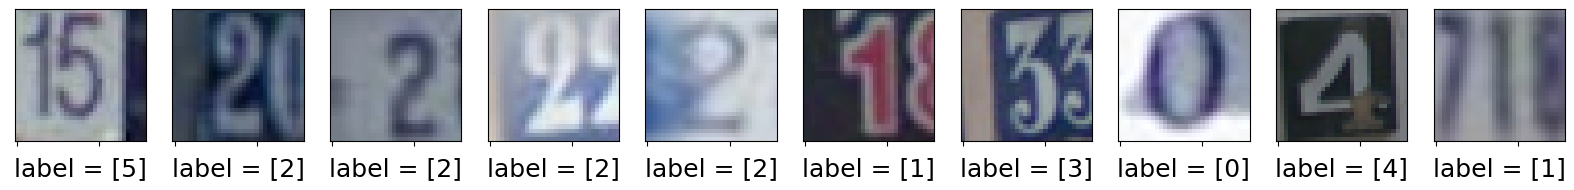

In [7]:
n = 10 
plt.figure(figsize=(20, 7))
for i in range(n):
    value = randint(0, 50000)
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(training_images[i+value,:,:,:])
    plt.gray()
    plt.xlabel("label = "+str(training_labels[i+value]), fontsize=18)


    ax.get_yaxis().set_visible(False)
    ax.set_xticklabels([])


plt.show()


In [8]:
GS_training_images = np.mean(training_images,keepdims=True,axis = -1)

GS_testing_images = np.mean(testing_images,keepdims=True,axis = -1)
print(GS_training_images.shape)

(73257, 32, 32, 1)


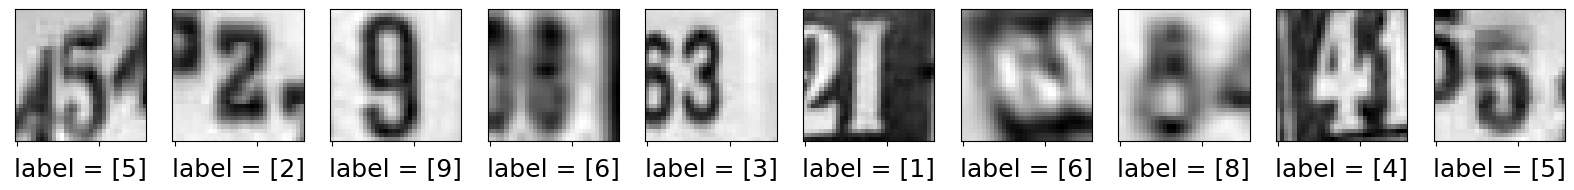

In [9]:

n = 10  
plt.figure(figsize=(20, 7))
for i in range(n):
    value = randint(0, 50000)
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(GS_training_images[i+value,:,:])
    plt.gray()
    plt.xlabel("label = "+str(training_labels[i+value]), fontsize=18)


    ax.get_yaxis().set_visible(False)
    ax.set_xticklabels([])


plt.show()

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least one callback during training, like a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [11]:
MLP_model = Sequential([
    

    Flatten(input_shape=(32, 32,1)),
    
      # dense layer 1
    Dense(256, activation='relu'),  
    
    # dense layer 2
    Dense(128, activation='relu'), 
    
      # output layer
    Dense(10, activation='softmax'),  
])

In [12]:
print(MLP_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               262400    
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 296,586
Trainable params: 296,586
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
ES_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
# This callback will stop the training when there is no improvement in
# the loss for three consecutive epochs.


MC_callback_best = ModelCheckpoint('MLP_model/best_model' , save_best_only= True ,save_weights_only=True , 
                                monitor="val_accuracy" )

In [14]:
MLP_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy']
                       )

In [15]:

MLP_history=MLP_model.fit( GS_training_images,training_labels_categorical,epochs=20 , batch_size= 128 ,validation_split=0.15,
                 callbacks=[ES_callback,MC_callback_best])



Epoch 1/20


2022-12-09 16:07:14.732570: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-09 16:07:14.902013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


485/487 [============================>.] - ETA: 0s - loss: 2.1465 - accuracy: 0.2302

2022-12-09 16:07:18.953501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


487/487 [==============================] - 5s 9ms/step - loss: 2.1459 - accuracy: 0.2304 - val_loss: 1.8550 - val_accuracy: 0.3533
Epoch 2/20
487/487 [==============================] - 4s 9ms/step - loss: 1.5705 - accuracy: 0.4706 - val_loss: 1.4183 - val_accuracy: 0.5317
Epoch 3/20
487/487 [==============================] - 5s 9ms/step - loss: 1.2990 - accuracy: 0.5823 - val_loss: 1.2536 - val_accuracy: 0.6006
Epoch 4/20
487/487 [==============================] - 4s 9ms/step - loss: 1.1815 - accuracy: 0.6269 - val_loss: 1.1539 - val_accuracy: 0.6466
Epoch 5/20
487/487 [==============================] - 4s 9ms/step - loss: 1.1086 - accuracy: 0.6533 - val_loss: 1.0779 - val_accuracy: 0.6668
Epoch 6/20
487/487 [==============================] - 4s 9ms/step - loss: 1.0624 - accuracy: 0.6703 - val_loss: 1.0333 - val_accuracy: 0.6820
Epoch 7/20
487/487 [==============================] - 4s 9ms/step - loss: 1.0161 - accuracy: 0.6890 - val_loss: 1.0573 - val_accuracy: 0.6667
Epoch 8/20
487/48

<AxesSubplot: >

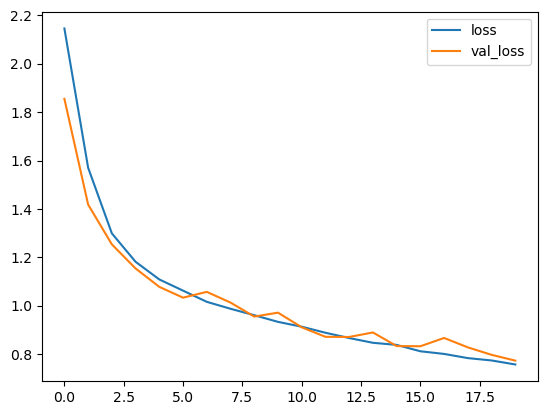

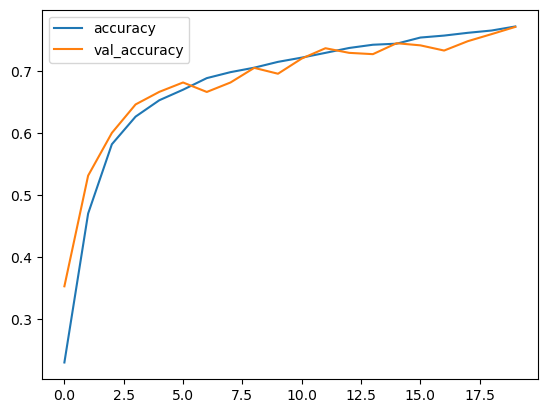

In [16]:

MLP_df = pd.DataFrame(MLP_history.history)
MLP_df.plot(y= ["loss","val_loss"],use_index = True)
MLP_df.plot(y= [ "accuracy","val_accuracy"] , use_index = True)

In [17]:
MLP_results = MLP_model.evaluate(GS_testing_images,to_categorical(testing_labels,10))

814/814 [==============================] - 5s 6ms/step - loss: 0.8751 - accuracy: 0.7469


In [18]:
print(f"testset loss = {MLP_results[0]} , testset accuracy = {MLP_results[1]}")

testset loss = 0.8750773072242737 , testset accuracy = 0.7468884587287903


## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model **must** use fewer trainable parameters than your MLP model.
* Compile and train the model (recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least one callback during training, like a ModelCheckpoint callback.
* **You should aim to beat the MLP model performance with fewer parameters!**
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [19]:
   CNN_model = Sequential([
        
        Conv2D(6,5,input_shape=(32,32,1)),
        BatchNormalization(),
        MaxPooling2D(2,strides = 2),
        Dropout(0.4), 
        Conv2D(16,5),
        BatchNormalization(),
        MaxPooling2D(2),
        Dropout(0.4), 
        Flatten(),
        Dense(128,activation = 'relu'),
        Dense(128,activation = 'relu'),
        Dense(10,activation= 'softmax')       
        
    ])

In [20]:
print(CNN_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 6)        24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 6)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 6)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 batch_normalization_1 (Batc  (None, 10, 10, 16)      

In [21]:
ES_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
# This callback will stop the training when there is no improvement in
# the loss for three consecutive epochs.


MC_callback_best = ModelCheckpoint('CNN_model/best_model' , save_best_only= True ,save_weights_only=True , 
                                monitor="val_accuracy" )

In [22]:
CNN_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy']
                       )


In [23]:
CNN_history=CNN_model.fit( GS_training_images,training_labels_categorical,epochs=25 , batch_size= 128 ,validation_split=0.15,
                 callbacks=[ES_callback,MC_callback_best])



Epoch 1/25


2022-12-09 16:10:07.359758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


487/487 [==============================] - ETA: 0s - loss: 1.4487 - accuracy: 0.5184

2022-12-09 16:10:15.767090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


487/487 [==============================] - 9s 18ms/step - loss: 1.4487 - accuracy: 0.5184 - val_loss: 0.8789 - val_accuracy: 0.7353
Epoch 2/25
487/487 [==============================] - 8s 17ms/step - loss: 0.7939 - accuracy: 0.7571 - val_loss: 0.6082 - val_accuracy: 0.8175
Epoch 3/25
487/487 [==============================] - 8s 17ms/step - loss: 0.6741 - accuracy: 0.7912 - val_loss: 0.5320 - val_accuracy: 0.8406
Epoch 4/25
487/487 [==============================] - 8s 17ms/step - loss: 0.6220 - accuracy: 0.8086 - val_loss: 0.5158 - val_accuracy: 0.8478
Epoch 5/25
487/487 [==============================] - 8s 17ms/step - loss: 0.5850 - accuracy: 0.8185 - val_loss: 0.4720 - val_accuracy: 0.8608
Epoch 6/25
487/487 [==============================] - 8s 17ms/step - loss: 0.5525 - accuracy: 0.8288 - val_loss: 0.4433 - val_accuracy: 0.8706
Epoch 7/25
487/487 [==============================] - 8s 17ms/step - loss: 0.5330 - accuracy: 0.8344 - val_loss: 0.4466 - val_accuracy: 0.8721
Epoch 8/25

<AxesSubplot: >

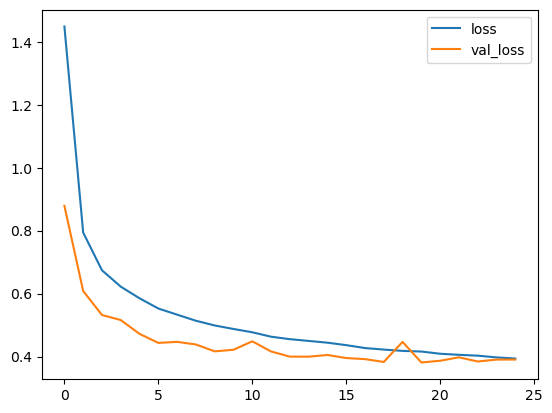

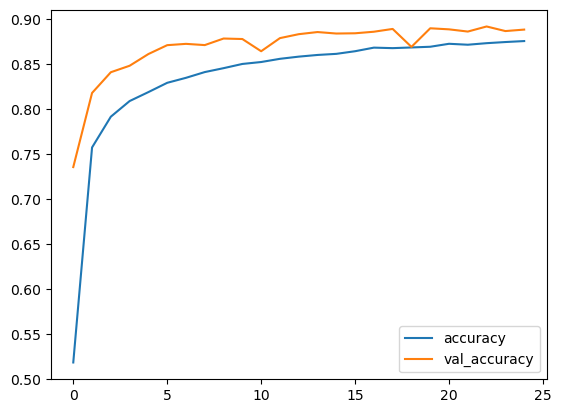

In [24]:
CNN_df = pd.DataFrame(CNN_history.history)
CNN_df.plot(y= ["loss","val_loss"],use_index = True)
CNN_df.plot(y= [ "accuracy","val_accuracy"] , use_index = True)

In [25]:
CNN_results = CNN_model.evaluate(GS_testing_images,to_categorical(testing_labels,10))

814/814 [==============================] - 6s 7ms/step - loss: 0.4672 - accuracy: 0.8636


In [26]:
print(f"testset loss = {CNN_results[0]} , testset accuracy = {CNN_results[1]}")

testset loss = 0.4672170579433441 , testset accuracy = 0.8635909557342529


## 4. Get model predictions
* Load the **best weights** for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [28]:
best_mlp = MLP_model
best_mlp.load_weights('MLP_model/best_model')


In [29]:
best_cnn = CNN_model
best_cnn.load_weights('CNN_model/best_model')

In [44]:
training_labels[training_labels == 0] = 10 
testing_labels[testing_labels == 0] = 10


X_train, X_val, y_train, y_val = train_test_split(GS_training_images, training_labels,
                                                  test_size=0.2, random_state=22)
num_test_images = X_val.shape[0]
idx = np.random.choice(num_test_images, 5)
def _test_model(model):

    random_test_images = X_val[idx, ...]
    random_test_labels = y_val[idx, ...]
    predictions = model.predict(random_test_images)
    fig, axes = plt.subplots(5, 2, figsize=(16, 12))
    fig.subplots_adjust(hspace=0.4, wspace=-0.2)
    for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
        axes[i, 0].imshow(np.squeeze(image))
        axes[i, 0].get_xaxis().set_visible(False)
        axes[i, 0].get_yaxis().set_visible(False)
        axes[i, 0].text(10., -1.5, f'Digit {label}')
        axes[i, 1].bar(np.arange(1,11), prediction)
        axes[i, 1].set_xticks(np.arange(1,11))
        axes[i, 1].set_title("Categorical distribution. Model prediction")
    plt.show()

1/1 [==============================] - 0s 18ms/step


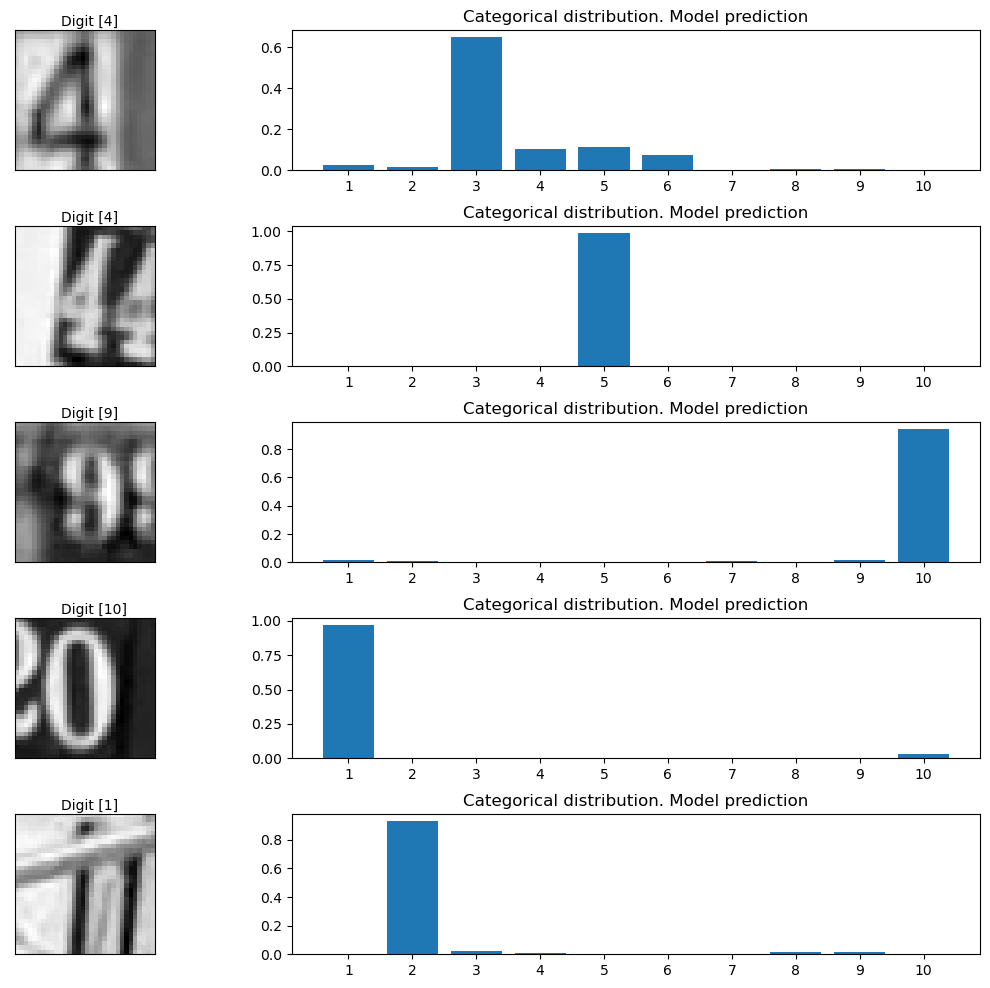

In [48]:
_test_model(MLP_model)

1/1 [==============================] - 0s 9ms/step


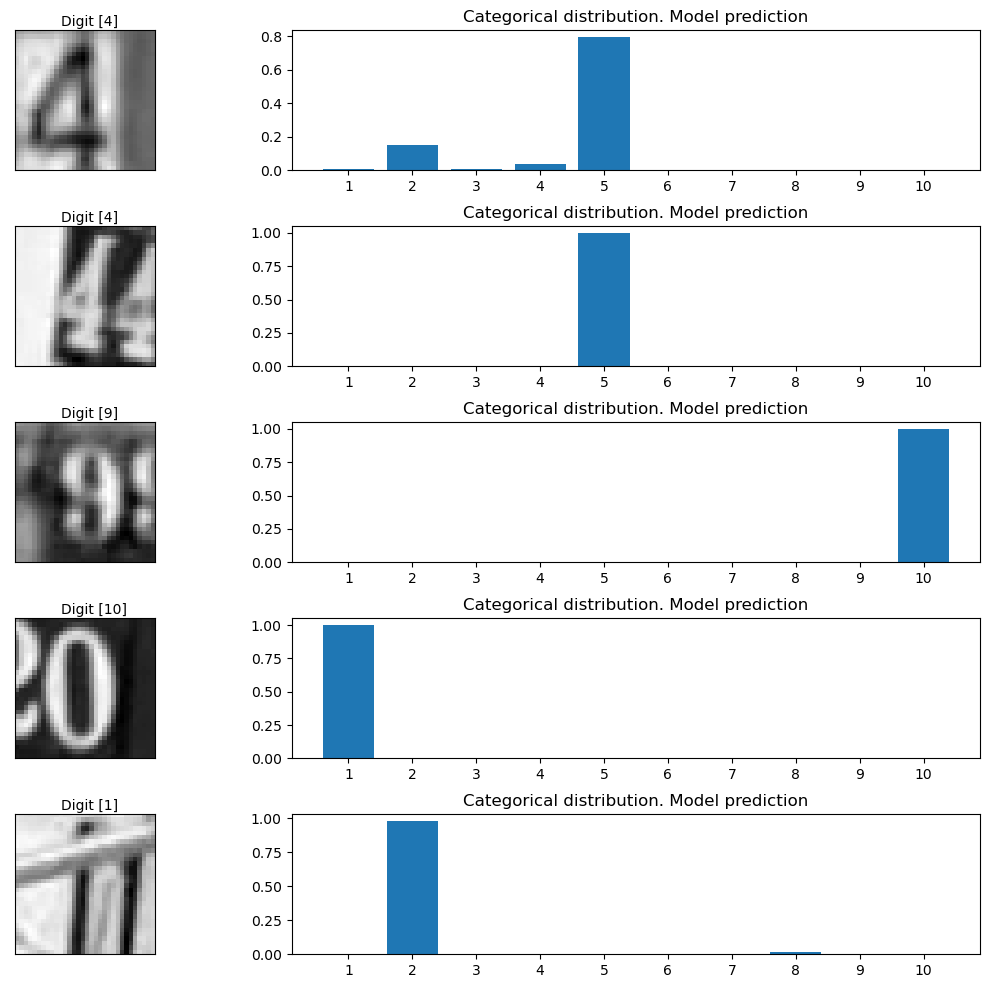

In [46]:
_test_model(CNN_model)